In [399]:
import numpy as np
import keras
import pandas as pd
import json
import imageio
from skimage.transform import resize
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [400]:
def load_data(mode):
    if mode == 'TRAIN':
        json_path = '../../data/reference_images_part1.json'
        images_path = '../../data/reference_images_part1/'
    elif mode == 'VAL':
        json_path = '../../data/images_part1_valid.json'
        images_path = '../../data/images_part1_valid/'
    else:
        raise ValueError('usupported mode')
    with open(json_path) as json_data:
        data = json.load(json_data)
    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])
    categories = pd.DataFrame(data['categories'])
    
    df = pd.DataFrame()
    
    
    X = []
    y = []
    y_desc = []
    occluded = []
    bboxes = []
    im_ids = []
    
    for instance in data['annotations']:
        im_id = instance['image_id']
        bbox = instance['bbox']
        y.append(instance['category_id'])
        bboxes.append(np.asarray(bbox).astype('int64'))
        #print(images.loc[images['id']==im_id]['file_name'])
        im_ids.append(images.loc[images['id']==im_id]['file_name'].values[0])
        y_desc.append(categories.loc[categories['id']==instance['category_id']]['name'].values[0])
        if mode=='TRAIN':
            occluded.append(False)
        elif mode=='VAL':
            occluded.append(instance['occluded'])
        
    df['bbox'] = bboxes
    df['y'] = y
    df['desc'] = y_desc
    df['im_id'] = im_ids
    df['occ'] = occluded
    
    return df

In [401]:
df

,bbox,y,desc,im_id
0,"[665, 448, 206, 174]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
1,"[475, 186, 236, 186]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
2,"[962, 76, 229, 217]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
3,"[778, 250, 163, 135]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
4,"[184, 377, 244, 194]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
...,...,...,...,...
139,"[791, 129, 277, 139]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png
140,"[345, 139, 271, 109]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png
141,"[895, 365, 177, 223]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png
142,"[155, 146, 163, 209]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png


In [565]:
class LoadData:

    
    def __init__(self, mode):
        self.files = []
        self.mode = mode
        if mode == 'TRAIN':
            self.images_path = '../../data/reference_images_part1/'
            self.json_path = '../../data/reference_images_part1.json'
            self.df = train_df
        elif mode == 'VAL':
            self.json_path = '../../data/images_part1_valid.json'
            self.images_path = '../../data/images_part1_valid/'
            self.df = val_df
        else:
            raise ValueError('usupported mode')

        for file in os.listdir(self.images_path):
                    if file.endswith('.png'):
                        try:
                            self.files.append(os.path.join(self.images_path, file))
                        except FileNotFoundError as e:
                            print(file)

    def _get_file_index(self):
        return [i for i in self.files]


    def __getitem__(self, index):
        X = np.asarray(Image.open(self.images_path+self.df.iloc[index]['im_id']))
        X = X[self.df.iloc[index]['bbox'][1]:self.df.iloc[index]['bbox'][1]+self.df.iloc[index]['bbox'][3],
              self.df.iloc[index]['bbox'][0]:self.df.iloc[index]['bbox'][0]+self.df.iloc[index]['bbox'][2],
              :3]
        
        def normalize(x):
            return x/255
        
        def preprocessing(X):
            data_x = np.zeros((600,600,3))
            mean=109.9818118

            temp_df = X
            temp_df_shape = X.shape
    
            max_shape = np.max(temp_df_shape)
            max_shape_orient = np.where(temp_df_shape==max_shape) # zwróci 0 albo 1
            temp_arr = np.zeros((max_shape,max_shape,3)) ## mozna czymś wypełnić tło
            
            if max_shape_orient[0][0] == 0:
                t = (temp_df_shape[0] - temp_df_shape[1])//2
                temp_arr[:,t:t+temp_df_shape[1],:] = temp_df
    
            elif max_shape_orient[0][0] == 1:
                t = (temp_df_shape[1] - temp_df_shape[0])//2
                temp_arr[t:t+temp_df_shape[0],:,:] = temp_df
            
            
            data_x = resize(temp_arr, (600, 600))
        
            data_x = np.where(data_x==0,mean,data_x)   

            return data_x
        
        return np.reshape(preprocessing(X), (1, 600, 600, 3))

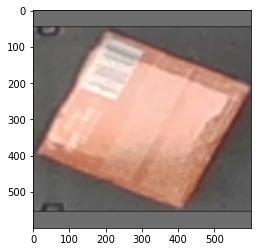

In [566]:
train_df = load_data('TRAIN')
loader = LoadData('TRAIN')
plt.imshow(loader[0][0].astype('int64'))

In [567]:
model_b7 = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(600, 600, 3),
    pooling='max',
    classes=1000,
    classifier_activation="softmax")

In [ ]:
embb7 = np.zeros((len(df), 2560))
for i in range(len(df)):
    embb7[i] = model_b7(loader[i])[0]

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(embb7)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 12
for lab in range(1, num_categories+2):
    indices = np.asarray(df['y'])==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
val_df = load_data('VAL')
val_gen = LoadData('VAL')

In [ ]:
results = []
for i in range(len(val_df)):
    if(i>0 and i%100==0):
        print(float(i)/len(val_df))
    if not val_df.iloc[i]['occ']:
        results.append(model_b7(val_gen[i])[0])
    else:
        results.append(np.NaN)

In [ ]:
from scipy.spatial import distance
import numpy as np

MAX_CLASS = 13 #maksymalne id klasy


def compute_distances(x, embedding, method=distance.cosine):
    distances = np.zeros((embedding.shape[0]))
    for i in range(embedding.shape[0]):
        distances[i] = method(embedding[i], x)
    return distances

In [ ]:
distances=[]

for i in range(len(results)):
    if results[i] is not np.NaN:
        distances.append(compute_distances(results[i], embb7))
    else:
        distances.append(np.NaN)

In [ ]:
def classify(distances, classes):
    '''
    same lengths
    distances - np.array
    classes - np.array
    returns: class
    '''
    weights = {cls: [] for cls in classes}
    for i in range(len(distances)):
        weights[classes[i]].append(distances[i])

    m = max(sum(list(map(lambda x: pow(x, -1), scores)))/len(scores) for scores in weights.values())
    for cls in weights.keys():
        lm = sum(list(map(lambda x: pow(x, -1), weights[cls])))/len(weights[cls])
        if lm == m:
            return cls


'''
distances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]
classes =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']
print('max: ', classify(distances, classes))
'''

In [ ]:
predictions = []


for i in range(len(distances)):
    if distances[i] is not np.NaN:
        predictions.append(classify(distances[i], train_df['y']))
    else:
        predictions.append(np.NaN)

In [ ]:
results_df = pd.DataFrame()
results_df['preds'] = predictions
results_df['y'] = val_df['y']

In [ ]:
off_res = results_df.dropna(how='any')

In [ ]:
off_res = off_res.drop(off_res.loc[off_res['y']==7].index)
off_res = off_res.drop(off_res.loc[off_res['y']>13].index)

In [ ]:
(off_res['preds'] == off_res['y']).sum()/(len(off_res))

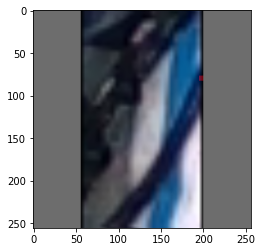

In [397]:
plt.imshow(val_gen[1722][0].astype('int64'))

In [378]:
labs = train_df['y'].unique()
labs.sort()
labs

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13])

In [391]:
off_res.loc[off_res['y'] == 6]

,preds,y
461,5.0,6
901,4.0,6
926,6.0,6
1722,4.0,6
2002,4.0,6
2501,4.0,6
2522,4.0,6
3576,6.0,6
3580,6.0,6
3605,6.0,6


In [369]:
off_res.loc[off_res['preds']!=off_res['y']].head(10)

,preds,y
23,4.0,8
28,4.0,8
36,4.0,8
38,4.0,9
39,4.0,8
43,4.0,8
48,4.0,9
50,4.0,8
51,8.0,9
65,4.0,8


In [388]:
deps = np.zeros((14,14))

for i in range(len(off_res)):
    deps[int(off_res.iloc[i]['preds']), int(off_res.iloc[i]['y'])] += 1

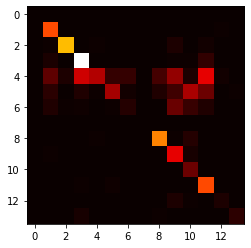

In [389]:
plt.imshow(deps, cmap='hot')

In [398]:
import tensorflow_addons as tfa

model_b7.compile(optimizer='adam',
                loss=tfa.losses.TripletSemiHardLoss(),
                metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
